In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import random
random.seed(4768)
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import processor
import hist
# from coffea import hist, processor 
# from coffea.hist import plot
from coffea.util import load, save
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
hists = {}
for year in ["2016preVFP","2016postVFP","2017","2018"]:
    hists[year] = load('../hists/hadmonotop'+year+'.merged')

In [3]:
###
# To find the a variable's working point
###

# iterating for each year
best_cuts = np.empty((len(hists.keys())))
for j,year in enumerate(hists.keys()):
    previous = None

    variable = 'TvsQCD'
    acc = 0.90
    cut_bin = 0 
    done = False
    
    # getting attributes from arbitary mass combination
    arbitrary_key = next(iter(hists[year][variable].keys()))
    nbins = hists[year][variable][arbitrary_key].view().size
    cut_value_array = hists[year][variable][arbitrary_key][{"region":slice(0,len,sum)}].axes.edges[0]
    assert len(cut_value_array)==nbins+1, "this isn't redundant"

    print('-'*25)
    print('Variable:', variable)
    print('Year:', year)
    print('Threshold: '+str(round(acc*100,2))+"%")
    #print('------------------------')
    while not done:
        print('-'*15)
        print('testing ',variable,'> %.2f' % cut_value_array[cut_bin+1])
    
        # the average ratio physically should be the same across all mass combinations
        p = random.choice(list(hists[year][variable].keys()))

        # the following should "integrate" according to https://github.com/CoffeaTeam/coffea/discussions/705
        #      but acts identical to the line following it 
        # yld_array = hists[year][variable][p][{"region":slice(0,len,sum)}].values()
        yld_array = hists[year][variable][p].values()
        yld = yld_array.sum()
        total = yld
        yld = yld - np.cumsum(yld_array)[cut_bin]
        ratio = yld / total
        print("ratio for {:0.2f} cut: {:0.2f}".format(cut_value_array[cut_bin+1],ratio))
        if (ratio < acc):
            # seeing if previous step was a better cut
            if (previous is not None) and (acc-ratio > previous-acc):
                cut_bin -= 1
            print('-'*15)
            print("Best cut for "+year+" is {:.2f} <- <- <-".format(cut_value_array[cut_bin+1]))
            print('-'*20)
            print('')
            best_cuts[j] = cut_value_array[cut_bin+1]
            done = True
        else:
            previous = ratio
            cut_bin += 1
            if cut_bin == nbins: 
                print('-'*15)
                print("Could not find cut")
                print('-'*25)
                print('')
                done = True


-------------------------
Variable: TvsQCD
Year: 2016preVFP
Threshold: 90.0%
---------------
testing  TvsQCD > 0.07
ratio for 0.07 cut: 0.79
---------------
Best cut for 2016preVFP is 0.07 <- <- <-
--------------------

-------------------------
Variable: TvsQCD
Year: 2016postVFP
Threshold: 90.0%
---------------
testing  TvsQCD > 0.07
ratio for 0.07 cut: 0.77
---------------
Best cut for 2016postVFP is 0.07 <- <- <-
--------------------

-------------------------
Variable: TvsQCD
Year: 2017
Threshold: 90.0%
---------------
testing  TvsQCD > 0.07
ratio for 0.07 cut: 0.80
---------------
Best cut for 2017 is 0.07 <- <- <-
--------------------

-------------------------
Variable: TvsQCD
Year: 2018
Threshold: 90.0%
---------------
testing  TvsQCD > 0.07
ratio for 0.07 cut: 0.73
---------------
Best cut for 2018 is 0.07 <- <- <-
--------------------



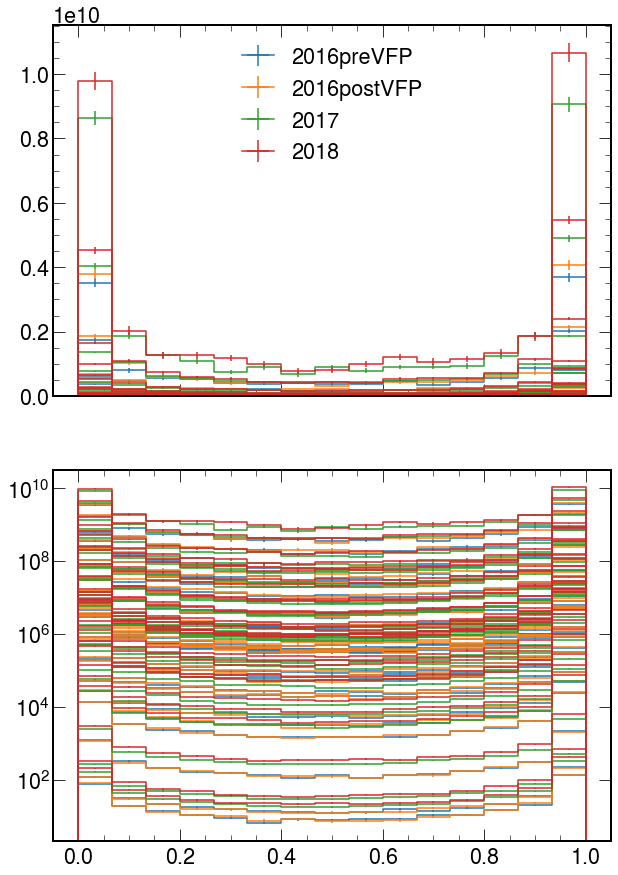

In [4]:
# These are all cutting on the first bin. Why?

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,15),sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_year = {"2016preVFP":colors[0],"2016postVFP":colors[1],"2017":colors[2],"2018":colors[3]}

for j,year in enumerate(hists.keys()):
    # getting attributes from arbitary mass combination
    arbitrary_key = next(iter(hists[year][variable].keys()))
    #for i,p in enumerate(hists[year][variable].keys()):
    #    hists[year][variable][p][{"region":sum}].plot()
    #counts, _, bins = hists[year][variable][arbitrary_key].to_numpy()
    #ax.hist(counts[0],bins,label="year")
    for i,p in enumerate(hists[year][variable].keys()):
        if i==0: 
            hists[year][variable][p][{"region":sum}].plot(ax=ax1,color=color_year[year],label=year)
            hists[year][variable][p][{"region":sum}].plot(ax=ax2,color=color_year[year],label=year)
        else: 
            hists[year][variable][p][{"region":sum}].plot(ax=ax1,color=color_year[year])
            hists[year][variable][p][{"region":sum}].plot(ax=ax2,color=color_year[year])
ax1.legend()
ax2.set_yscale("log")
plt.show()


In [5]:
# The all have fairly well-shared extreme skewing, meaning the first bin
# always has >10% of the counts, so the cut is always on the first bin

The best fit for a random mass combination with a random mass combination's cumulative curve

There is some varience in terms of how accuracte the fitting is between different runs of this cell

For accuracy <= 0.9 this code will always cut at the first bin, and due to the 
    small amount of bins, this leads to differences in goal vs realized accuracy



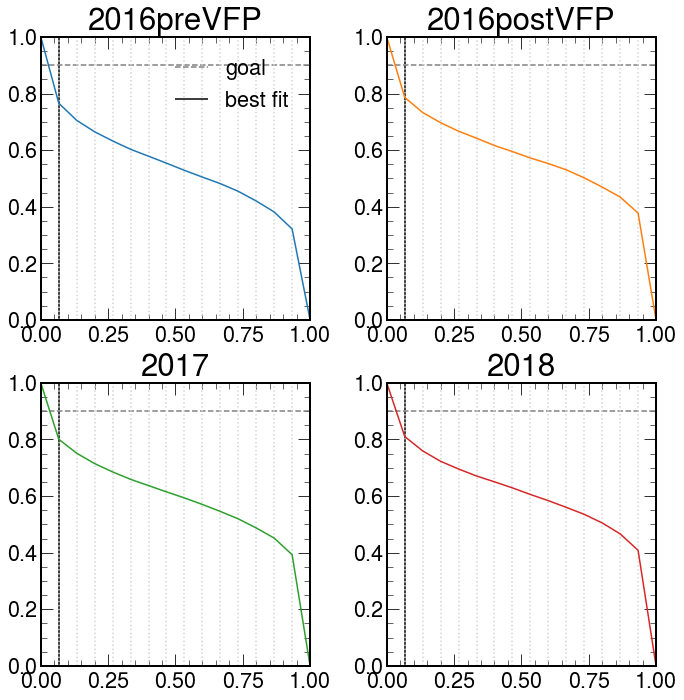

In [6]:
print("The best fit for a random mass combination with a random mass combination's cumulative curve")
print("\nThere is some varience in terms of how accuracte the fitting is between different runs of this cell")

if acc <= 0.9:
    print("\nFor accuracy <= 0.9 this code will always cut at the first bin, and due to the \n\
    small amount of bins, this leads to differences in goal vs realized accuracy\n")

fig, axs = plt.subplots(2,2)
axs = axs.flatten()
plt.tight_layout()
for i,year in enumerate(hists.keys()):
    p = random.choice(list(hists[year][variable].keys()))
    cumulative = np.cumsum(hists[year][variable][p][{"region":sum}].values())
    axs[i].plot(cut_value_array,[1,*(1-cumulative/cumulative[-1])],color=color_year[year])
    axs[i].set_title(year)
    axs[i].hlines((acc),0,1,linestyle='--',color='gray',label="goal")
    axs[i].vlines((best_cuts[i]),0,1,linestyle='-',color='k',label="best fit")
    axs[i].vlines(cut_value_array,0,1,linestyle='dotted',color='lightgray')
    axs[i].set_ylim(0,1)
    axs[i].set_xlim(0,1)
axs[0].legend()
plt.show()